<a href="https://colab.research.google.com/github/MLandML/MLandML/blob/learning_projects/Basic_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch,pdb #pdb debugger
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms #we can transform the images in the training data in any way
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm #library for creating progress bars
import matplotlib.pyplot as plt

In [ ]:
#visualization function
def show(tensor,ch=1,size=(28,28),num=16): #tensor: 128x784
  data = tensor.detach().cpu().view(-1,ch,*size)  #detach:detaching from all gradient computation #view: reshape,128x1x28x28
  grid = make_grid(data[:num],nrow=4).permute(1,2,0) # 1x28x28 = 28x28x1
  plt.imshow(grid)
  plt.show()

In [ ]:
from torchvision.transforms.transforms import ToTensor
#main parameters and hyperparameters
epochs = 500
cur_step = 0
info_step = 100
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64 #dim of input of generator (noise)
lr = 0.0001
loss_func = nn.BCEWithLogitsLoss()

device = 'cuda' #nvidia's gpu

dataloader = DataLoader(MNIST('.',download=True,transform=transforms.ToTensor()),shuffle=True,batch_size=128)

In [ ]:
#generator
def genblock(inp,out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace=True)
  )

class Generator(nn.Module):
  def __init__(self,z_dim=64,i_dim=784,h_dim=128):
    super().__init__()
    self.gen = nn.Sequential(
        genblock(z_dim,h_dim), #64 to 128
        genblock(h_dim,h_dim*2), #128 to 256
        genblock(h_dim*2,h_dim*4), #256,512
        genblock(h_dim*4,h_dim*8), #512,1024
        nn.Linear(h_dim*8,i_dim) #1024,784
    )

  def forward(self,noise):
    return self.gen(noise)

def gen_noise(number, z_dim):
  return torch.randn(number,z_dim).to(device)

In [ ]:
#discriminator
def discblock(inp,out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self,i_dim=784,h_dim=256):
    super().__init__()
    self.disc = nn.Sequential(
        discblock(i_dim,h_dim*4), #784,1024
        discblock(h_dim*4,h_dim*2),
        discblock(h_dim*2,h_dim),
        nn.Linear(h_dim,1)
    )

  def forward(self,image):
    return self.disc(image)

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(),lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(),lr=lr)

In [ ]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
  )
)

In [ ]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([8, 7, 3, 3, 1, 9, 8, 4, 2, 1])


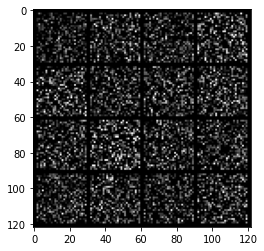

In [ ]:
x,y = next(iter(dataloader))
print(x.shape,y.shape)
print(y[:10])

noise = gen_noise(128,z_dim)
fake = gen(noise)
show(fake)

In [ ]:
#gen_loss
def calc_gen_loss(loss_func,gen,disc,number,z_dim):
  noise = gen_noise(number,z_dim)
  fake = gen(noise)
  pred = disc(fake)
  targets = torch.ones_like(pred)
  gen_loss = loss_func(pred,targets)
  return gen_loss

#disc_loss
def calc_disc_loss(loss_func,gen,disc,number,z_dim,real):
  noise = gen_noise(number,z_dim)
  fake= gen(noise)
  disc_fake = disc(fake.detach())
  disc_fake_targets = torch.zeros_like(disc_fake)
  disc_fake_loss = loss_func(disc_fake,disc_fake_targets)

  disc_real = disc(real)
  disc_real_targets = torch.ones_like(disc_real)
  disc_real_loss = loss_func(disc_real,disc_real_targets)

  disc_loss = (disc_fake_loss+disc_real_loss)/2.0
  return disc_loss

In [ ]:
#training

for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    #disc_training
    disc_opt.zero_grad()

    cur_batch_size = len(real) #128x1x28x28
    real = real.view(cur_batch_size,-1) #128x784
    real = real.to(device)

    disc_loss = calc_disc_loss(loss_func,gen,disc,cur_batch_size,z_dim,real)
    disc_loss.backward(retain_graph=True)
    disc_opt.step() #tweak and update the parameters of the disc_opt after each step

    #gen_training
    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_func,gen,disc,cur_batch_size,z_dim)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()

    #visualization and steps
    mean_gen_loss += gen_loss.item()/info_step #.item() converts tensor to a number
    mean_disc_loss += disc_loss.item()/info_step

    if cur_step % info_step == 0 and cur_step>0:
      fake_noise = gen_noise(cur_batch_size,z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)

      print(f"{epoch}: step {cur_step}/ Gen_loss:{mean_gen_loss}/disc_loss:{mean_disc_loss}")
      mean_gen_loss,mean_disc_loss = 0,0

    cur_step +=1
